<a href="https://colab.research.google.com/github/bokbokobama/wordle-solver/blob/main/wordleBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wordle Bot by Henry Gelber

### Overview
---
Wordle is a daily word game which challenges its players to find the correct five-letter word with only six tries and minimal feedback. With Wordle Bot, I've attempted to automate the Wordle-solving process using frequency analysis and weighted scoring.

### How to play Wordle (without the bot)
---
To start the game, enter any word, for example:

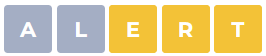

The A and L are gray, which means they don't appear in the word. The E, R, and T are in the word, but aren't in the right spots.

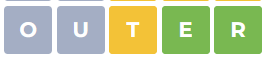

O and U don't appear in the word. T still isn't in the right position, but E and R are.

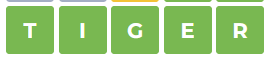

All five letters are green, meaning they're in the correct spots and you've just guessed the word!


### Using the bot
After starting, the bot will output an initial five-letter guess (most likely 'ALERT'). Enter this guess into Wordle, which will give you feedback by coloring each letter black, yellow, or green. 

In the terminal underneath the code block, input the colors of the letters in the form of a string of numbers as follows:

⬛ = 0 $\quad$ 🟨 = 1 $\quad$ 🟩 = 2

For example, 🟩🟨🟩⬛⬛ = 21200

Once you've entered this number and hit enter, the program will generate a new guess. Continue playing until you either win (by entering `22222`) or run out of guesses. 


## Sample Game
---
Code blocks are program output, lines beginning with `>` are user input, and images are game state in Wordle.


`Guess 1: alert (Confidence: 0.0011)`

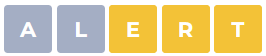

`> 00111`

`Guess 2: outer (Confidence: 0.0373)`

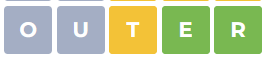

`> 00122`

`Guess 3: tiger (Confidence: 0.3846)`

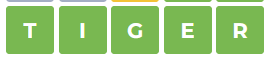

`> 22222`

`Game over, the answer was TIGER`

`You successfully guessed the word in 3 guesses`

In [ ]:

##@markdown ## Step 1. Initialize Program
##@markdown Download word lists from https://github.com/bokbokobama/wordle-solver. Then, run this program and upload the lists. You only need to do this once per session.

##@markdown *You can show or hide code by double clicking here.*


##<+><+><+><+><+><+><+><+><+><+>
##1. List Initialization

#Parse file to list
import os

def wordList(file):
    with open(file,'r') as f:
        words = f.read().splitlines()
    return words

if(os.path.isfile('wordle-answers-alphabetical.txt') == False):
#File upload
  from google.colab import files
  print('Download word lists from https://github.com/bokbokobama/wordle-solver')
  uploaded = files.upload()

#Define lists as variables
answerList = wordList('wordle-answers-alphabetical.txt')
antiWordList = wordList('wordle-allowed-guesses.txt')
mainWordList = wordList('sgb-words.txt')
print('Word lists sucessfully assigned.')

# Initialize general purpose lists
cleanAlphabet = []
cleanBoardState = []
for i in range(97, 123):
  cleanAlphabet.append(chr(i))
  cleanBoardState.append(False)

cleanWordState = ['_', '_', '_', '_', '_']
caseList = ['00000', '00001', '00002', '00010', '00011', '00012', '00020', '00021', '00022', '00100', '00101', '00102', '00110', '00111', '00112', '00120', '00121', '00122', '00200', '00201', '00202', '00210', '00211', '00212', '00220', '00221', '00222', '01000', '01001', '01002', '01010', '01011', '01012', '01020', '01021', '01022', '01100', '01101', '01102', '01110', '01111', '01112', '01120', '01121', '01122', '01200', '01201', '01202', '01210', '01211', '01212', '01220', '01221', '01222', '02000', '02001', '02002', '02010', '02011', '02012', '02020', '02021', '02022', '02100', '02101', '02102', '02110', '02111', '02112', '02120', '02121', '02122', '02200', '02201', '02202', '02210', '02211', '02212', '02220', '02221', '02222', '10000', '10001', '10002', '10010', '10011', '10012', '10020', '10021', '10022', '10100', '10101', '10102', '10110', '10111', '10112', '10120', '10121', '10122', '10200', '10201', '10202', '10210', '10211', '10212', '10220', '10221', '10222', '11000', '11001', '11002', '11010', '11011', '11012', '11020', '11021', '11022', '11100', '11101', '11102', '11110', '11111', '11112', '11120', '11121', '11122', '11200', '11201', '11202', '11210', '11211', '11212', '11220', '11221', '11222', '12000', '12001', '12002', '12010', '12011', '12012', '12020', '12021', '12022', '12100', '12101', '12102', '12110', '12111', '12112', '12120', '12121', '12122', '12200', '12201', '12202', '12210', '12211', '12212', '12220', '12221', '12222', '20000', '20001', '20002', '20010', '20011', '20012', '20020', '20021', '20022', '20100', '20101', '20102', '20110', '20111', '20112', '20120', '20121', '20122', '20200', '20201', '20202', '20210', '20211', '20212', '20220', '20221', '20222', '21000', '21001', '21002', '21010', '21011', '21012', '21020', '21021', '21022', '21100', '21101', '21102', '21110', '21111', '21112', '21120', '21121', '21122', '21200', '21201', '21202', '21210', '21211', '21212', '21220', '21221', '21222', '22000', '22001', '22002', '22010', '22011', '22012', '22020', '22021', '22022', '22100', '22101', '22102', '22110', '22111', '22112', '22120', '22121', '22122', '22200', '22201', '22202', '22210', '22211', '22212', '22220', '22221', '22222']

#<+><+><+><+><+><+><+><+><+><+>
# 2. List Validation

# Runs the validate function for every word in the list
def validateIterate(wordList, wordState, boardState, game):
  returnWordList = []
  for word in wordList:
    if(validate(word, wordState, boardState, game) == True):
      returnWordList.append(word)
  return(returnWordList)

# Removes any words which cannot possibly be the correct word
def validate(word, wordState, boardState, game):
  if(validateGreen(word, wordState) == True
  and validateYellow(word, wordState, game) == True
  and validateBlack(word, boardState) == True):
    return(True)
  else:
    return(False)

# Removes any words which do not have a green letter in the correct spots
def validateGreen(word, wordState):
  for i in range(5):
    if(wordState[i].isupper() == True):
      if(word[i].upper() != wordState[i]):
        return(False)
  return(True)

# Removes any words which either do not have a yellow letter or have a yellow letter in the same spot
def validateYellow(word, wordState, game):
  for i in range(5):
    if(wordState[i].islower() == True):
      if(wordState[i].lower() not in word):
        return(False)
    if(game == 'wordle' or game == 'absurdle'):
      try:
        if(wordState[i] == word[i]):
          return(False)
      except:
        print(str(wordState) + str(word))
  return(True)

# Removes any words which contain letters that have already been eliminated
def validateBlack(word, boardState):
  alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
  for i in range(26):
    if(boardState[i] == True):
      if(alphabet[i] in word):
        return(False)
  return(True)


#<+><+><+><+><+><+><+><+><+><+>
# 3a. Word Score Generation (simple)

# Counts the frequency of each letter in the current word list
def DistributionScore(wordList):
  alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
  letterHits = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

  for word in wordList:
    for letter in word:
      for i in range(26):
          if(letter == alphabet[i]):
            letterHits[i] += 1
            break
  
  return letterHits

# Scores a word based on how often its letters appear in the distribution list. Encourages words with all unique letters.
def simpleWordScore(word, distributionScore):
  alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
  score = 0
  for i in range(26):
    if(alphabet[i] in word):
      score += distributionScore[i]
  return(score)

# Runs the wordScore function for every word in the list and returns the best (or worst) word and score.
def simpleWordScoreIterate(wordList, distributionScore, game):
  bestScore = -1
  bestWord = ''
  for word in wordList:
    score = simpleWordScore(word, distributionScore)
    if(score > bestScore):
      bestScore = score
      bestWord = word
  return(bestWord, bestScore)

# Scores a word based on how often its letters appear in the distribution list. Encourages words with all unique letters.
def simpleWordScore(word, distributionScore):
  alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
  score = 0
  for i in range(26):
    if(alphabet[i] in word):
      score += distributionScore[i]
  return(score)

#<+><+><+><+><+><+><+><+><+><+>
# 3b. Word Score Generation (advanced)
def advancedWordScoreIterate(boardState, wordList, game, caseList):
  bestScore = -1
  bestWord = ''
  for word in wordList:
    score = advancedWordScore(word, boardState, game, wordList, caseList)
    if(score > bestScore):
      bestScore = score
      bestWord = word
  return(bestWord, bestScore)

def advancedWordScore(word, boardState, game, wordList, caseList):
  score = -1
  for testCase in caseList:
    testWordState, testBoardState, wordFound, tiles = feedbackCheck(word, boardState, testCase, game)
    score += len(validateIterate(wordList, testWordState, testBoardState, game))
  return(score)


#For every word:
  #For every test case
    #Simulate the results of that test case
    #With those results, clone the word list, eliminate words, and count those remaining.
    #Add that number to the score.


#<+><+><+><+><+><+><+><+><+><+>
# 4. User Feedback Request and Parse

# Requests and parses user feedback into a workable format, then identifies and stores green, yellow, and eliminated letters.
def feedbackCheck(word, boardState, checksum, game):
  alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
  wordState = ['', '', '', '', '']
  checksum = list(checksum)
  wordFound = False
  output = ['', '', '', '', '']
  tiles = ''
  if(len(checksum)<5):
    print('Invalid entry, please try again or enter \'ignore\' to skip the word.')
    return(feedbackCheck(word, boardState, input(), game))
  if(checksum == ['2', '2', '2', '2', '2']):
    wordFound = True

  # Black cells
  for i in range(5):
    if(checksum[i] == '0'):
      wordState[i] = '_'
      output[i] = '⬛'
      for j in range(26):
        if(word[i] == alphabet[j]):
          boardState[j] = True

  # Green cells
  for i in range(5):
    if(checksum[i] == '2'):
      wordState[i] = word[i].upper()
      output[i] = '🟩'
      for j in range(26):
        if(word[i] == alphabet[j]):
          boardState[j] = False

  # Yellow cells
  for i in range(5):
    if(checksum[i] == '1'):
      wordState[i] = word[i]
      output[i] = '🟨'
      for j in range(26):
        if(word[i] == alphabet[j]):
          boardState[j] = False
  
  for icon in output:
    tiles += icon
  return(wordState, boardState, wordFound, tiles)


#<+><+><+><+><+><+><+><+><+><+>
# 5. Main Module

# Puts all of the above modules together
def wordleBot(wordList, simulate, answer, algorithm):
  game = 'wordle'
  #wordList = mainWordList
  wordFound = False
  boardState = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
  wordState = ['_', '_', '_', '_', '_']
  guess = 0

  # Gameplay loop
  
  while(wordFound == False or guess <= 6):
    guess += 1 # Increment guess
    wordList = validateIterate(wordList, wordState, boardState, game) # Iterate through word list and remove invalid words
    if(algorithm == 'simple'):
      distributionScoreList = DistributionScore(wordList) # Update distribution list
      bestWord, bestScore = simpleWordScoreIterate(wordList, distributionScoreList, game) # Find best scoring word
    elif(algorithm == 'experimental'):
      bestWord, bestScore = advancedWordScoreIterate(boardState, wordList, game, caseList)
    if(bestWord == ''):
      print('Error: no valid word in list.\nRestart the module to play again.')
      break
    print('Guess ' + str(guess) + ': ' + bestWord + ' (Confidence: ' + str(round((5*(1/bestScore)), 4)) + ')\n> ', end = '') # Print best scoring word
    if(simulate == False):
      wordState,boardState,wordFound, tiles = feedbackCheck(bestWord, boardState, input(), game) # Input and parse user feedback
    else:
      wordState,boardState,wordFound, tiles = feedbackCheck(bestWord, boardState, wordleSim(answer, bestWord), game) # Input and parse user feedback
    print(tiles)
    print()
    if(guess == 6 or wordFound == True): # Check for win or lose condition
      print()
      if(wordFound == True): # Win condition

        print('Word found! The word was ' + bestWord + '.')
        print('You found the word in ' + str(guess) + ' guesses.')
      else: # Lose condition
        print('You failed to find the correct word in 6 tries.')
      print('Restart the module to play again')
      break
    wordList.remove(bestWord) # Remove the word just guessed to avoid an infinite loop
  return(bestWord, guess)
  # End of game


#<+><+><+><+><+><+><+><+><+><+>
# 6. Simulation

def wordleSim(word, guess):
  wordState = ['_', '_', '_', '_', '_']
  returnStr = ''
  for i in range(5):
    try:
      if(guess[i] == word[i]):
        wordState[i] = '2'
      elif(guess[i] in word):
        wordState[i] = '1'
      else:
        wordState[i] = '0'
    except:
      print(guess)
      print(word)
      pass
  for i in wordState:
    returnStr += i
  return returnStr

#<+><+><+><+><+><+><+><+><+><+>
# 7. Accuracy Check

def simulator():
  accuracy = [0, 0, 0, 0, 0, 0, 0]
  fails = []

  for answer in answerList:
    word, guess = wordleBot(answerList, True, answer)
    if(guess < 7):
      accuracy[guess - 1] += 1
    else:
      accuracy[6] += 1
      fails += str(word)

  print(accuracy)
  for i in range(len(fails)):
    print(fails[i], end = '')
    if (i+1) % 5 == 0:
      print()
    

In [ ]:
#@markdown ##Step 2. Run Interface

#@markdown Daily Wordle : https://www.nytimes.com/games/wordle/index.html

#@markdown Wordle : https://wordlegame.org/ 

#@markdown ⬛ = 0 $\quad$ 🟨 = 1 $\quad$ 🟩 = 2

#@markdown 🟩🟨🟩⬛⬛ = 21200

#@markdown Simple algorithm: fast, based on frequency analysis

#@markdown Experimental algorithm: slower, based on expected value

#@markdown *Instructions for use can be found below. You can show or hide code by double clicking here.*

algorithm = "simple" #@param ["simple", "experimental"]
solveForWord = False 
##@param {type:"boolean"}
if(solveForWord == True):
  wordToSolve = 'tiger' 
##@param {type:"string"}
else: wordToSolve = 'blank'

if(wordToSolve in answerList):
  wordleBot(answerList, solveForWord, wordToSolve, algorithm)
else:
  print('Word not found in answer list, please try a different word or change the list used')
# answerList: list of every possible correct answer (recommended)
# mainWordList: uncurated list of five-letter words
# antiWordList: list of every word accepted by Wordle (not recommended)

### Test cases

**On input mode:**

any string of 0s, 1s, and 2s which is five characters long - should operate normally

a string of five 2s - should print a win message and terminate the program

any alphanumeric string which is < five characters - should reject the string and request a new one

any string of 0s, 1s, and 2s which is >= five characters - should accept the string and run only the first five characters

a string of letters >= 5 characters - should accept string and remove the word from the list, but will not update boardState or wordState

an alphanumeric string containing some 0s, 1s, and 2s >= 5 characters long - should correctly process any 0s, 1s, and 2s in the corresponding positions

**On solver mode:**

A valid five letter word - should operate normally

A valid word of length != 5 - should reject word with rejection message

An invalid word or string of length 5 - should reject word with rejection message

